Cell Detection and Classification in Full Field-of-View (FOV) Images

🧠 Project Description 
In this project, we use a trained Convolutional Neural Network (CNN) to automatically classify individual cells as live or dead within a full microscopy field-of-view (FOV) image.

The model was previously trained on single-cell image crops. Here, we process full FOV images by:

Segmenting individual cells

Preprocessing each detected region

Predicting each cell's state using the trained CNN

Visualizing results by overlaying predictions on the original FOV image

This workflow simulates how a model would be deployed in a real laboratory setting for high-throughput viability analysis.

Step 1: Set Up Environment and Load Required Libraries

In [12]:
# 📦 Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import cv2
#!pip install tiffile
import tifffile as tiff

import tensorflow as tf
# 🧠 Deep learning: load your trained CNN model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array



   ---------------------------------------- 2/2 [tiffile]



Step 2: Load the Trained Model

In [13]:
# 🔍 Load the trained live/dead classification model
model_path = 'astrocyte_live_dead_model.keras'
model = load_model(model_path)

print("✅ Model loaded successfully.")


✅ Model loaded successfully.


 Step 3: Load and Visualize the Full FOV Image

Image shape: (704, 865)
Data type: uint8


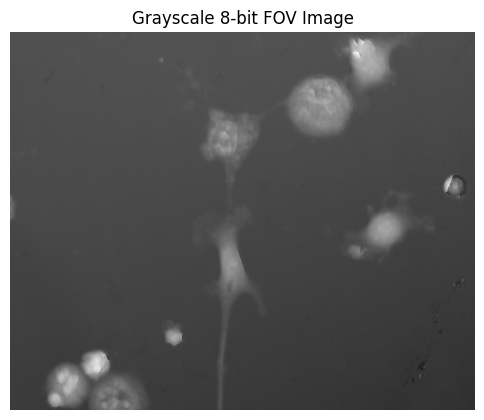

In [203]:


# Load the image using PIL
image_path = 'fov_example4.tif'  # Use your actual path
image_raw = tiff.imread(image_path)

# 🔍 Check the shape and type of the image
print("Image shape:", image_raw.shape)
print("Data type:", image_raw.dtype)

# 🧮 Convert to 8-bit grayscale if it's not already
if image_raw.dtype != np.uint8:
    image_8bit = cv2.normalize(image_raw, None, 0, 255, cv2.NORM_MINMAX)
    image_8bit = image_8bit.astype(np.uint8)
else:
    image_8bit = image_raw.copy()

# ✅ Preview the grayscale image
plt.figure(figsize=(6, 6))
plt.imshow(image_8bit, cmap='gray')
plt.title('Grayscale 8-bit FOV Image')
plt.axis('off')
plt.show()


Step 4: Segment Cells Using Basic Thresholding and Contour Detection

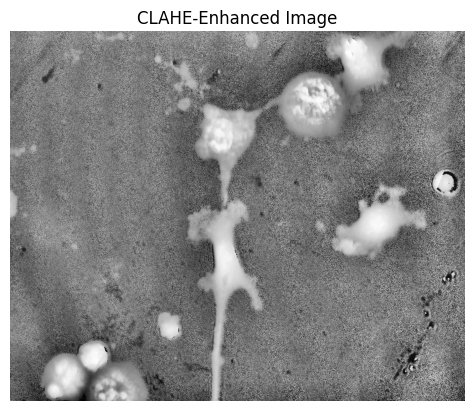

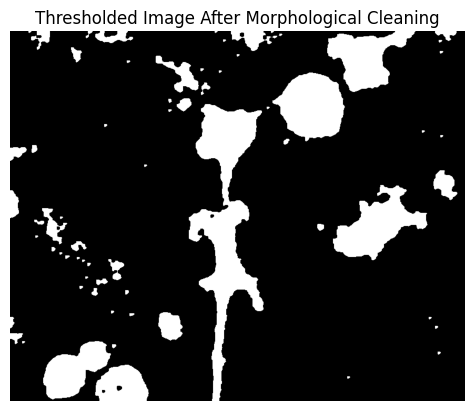

In [214]:
# 1. Enhance contrast using CLAHE
clahe = cv2.createCLAHE(clipLimit=25.0, tileGridSize=(8, 8))
enhanced = clahe.apply(image_8bit)

# 2. Preview the enhanced image
plt.imshow(enhanced, cmap='gray')
plt.title('CLAHE-Enhanced Image')
plt.axis('off')
plt.show()

# 3. Apply Otsu threshold, then adjust it to be more inclusive
otsu_thresh_val, _ = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
adjusted_thresh_val = max(0, otsu_thresh_val -10)

# 4. Apply adjusted threshold
_, thresh = cv2.threshold(enhanced, adjusted_thresh_val, 255, cv2.THRESH_BINARY_INV)

# 5. Invert if needed (cells in white)
thresh = cv2.bitwise_not(thresh)

# 6. Morphological noise cleanup
# Define a small elliptical kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))

# Apply opening (remove small white spots)
thresh_cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Then apply closing (fill small holes in white regions)
thresh_cleaned = cv2.morphologyEx(thresh_cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)

# 7. Show cleaned binary mask
plt.imshow(thresh_cleaned, cmap='gray')
plt.title('Thresholded Image After Morphological Cleaning')
plt.axis('off')
plt.show()

In [215]:
# Find contours — external only (we care about whole cells)
contours, _ = cv2.findContours(
    thresh_cleaned,                    # binary image with cells in white
    cv2.RETR_EXTERNAL,         # only outer boundaries
    cv2.CHAIN_APPROX_SIMPLE    # compress contour representation
)

print(f"🔍 Detected {len(contours)} potential cells.")


🔍 Detected 68 potential cells.


✅ Kept 12 contours after filtering with min_area = 700
✅ Kept 9 contours after aspect ratio filtering


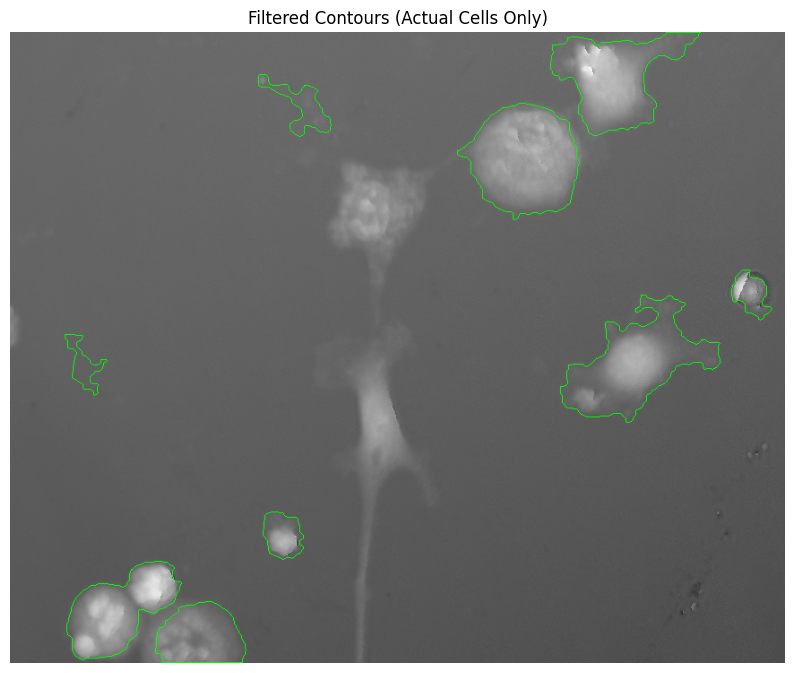

In [216]:
# Filter out very small contours — adjust min_area as needed
min_area = 700  # 👈 try 300–1000 based on your image scale
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

print(f"✅ Kept {len(filtered_contours)} contours after filtering with min_area = {min_area}")
good_contours = []
for cnt in filtered_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h if h > 0 else 0
    if 0.5 < aspect_ratio < 2.0:  # Accept roughly square/oval shapes
        good_contours.append(cnt)

print(f"✅ Kept {len(good_contours)} contours after aspect ratio filtering")

# Draw only the good contours
image_filtered = cv2.cvtColor(image_8bit, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image_filtered, good_contours, -1, (0, 255, 0), 1)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_filtered, cv2.COLOR_BGR2RGB))
plt.title('Filtered Contours (Actual Cells Only)')
plt.axis('off')
plt.show()


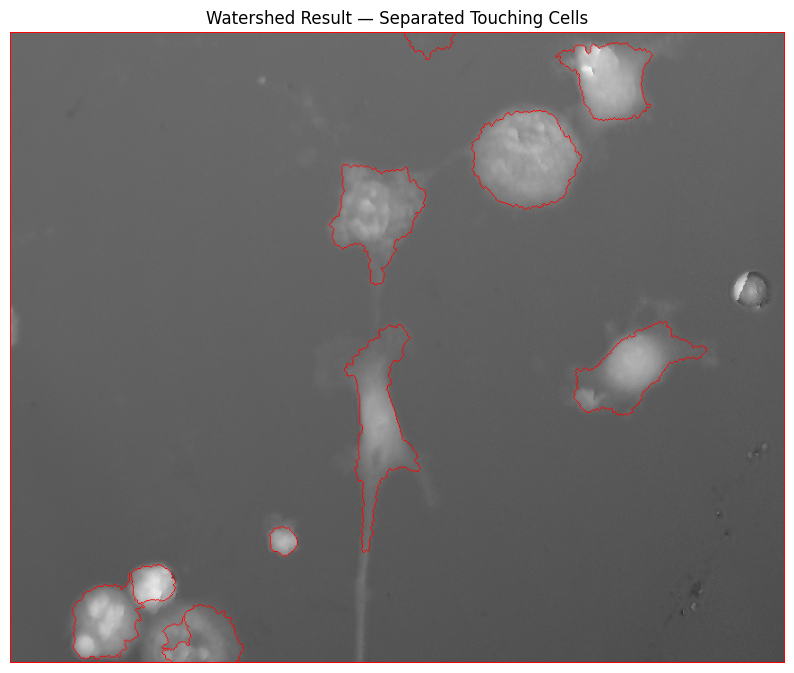

In [226]:
# 1. Apply morphological closing to close gaps
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
closed = cv2.morphologyEx(thresh_cleaned, cv2.MORPH_CLOSE, kernel)

# 2. Compute distance transform
dist_transform = cv2.distanceTransform(closed, cv2.DIST_L2, 5)

# 3. Threshold to get sure foreground (cell centers)
_, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# 4. Get sure background
sure_bg = cv2.dilate(closed, kernel, iterations=7)

# 5. Find unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

# 6. Label markers for watershed
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1  # so background is not 0
markers[unknown == 255] = 0  # mark unknown regions

# 7. Convert grayscale image to BGR for watershed
image_ws = cv2.cvtColor(image_8bit, cv2.COLOR_GRAY2BGR)

# 8. Apply watershed
cv2.watershed(image_ws, markers)

# 9. Mark the boundary (pixels set to -1 by watershed)
image_ws[markers == -1] = [0, 0, 255]  # Red boundary lines
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_ws, cv2.COLOR_BGR2RGB))
plt.title('Watershed Result — Separated Touching Cells')
plt.axis('off')
plt.show()



In [227]:
from tensorflow.keras.preprocessing.image import img_to_array

# Copy original image for drawing results
image_annotated = cv2.cvtColor(image_8bit, cv2.COLOR_GRAY2BGR)

# Count classes
live_count = 0
dead_count = 0

# Loop through each unique marker label (exclude background=1 and border=-1)
for label in np.unique(markers):
    if label in [1, -1]:
        continue  # skip background and boundary

    # Create a mask for the current label
    mask = np.uint8(markers == label) * 255

    # Find contour of the current cell
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        continue

    # Get bounding box of the contour
    x, y, w, h = cv2.boundingRect(contours[0])

    # Filter out very small regions (noise)
    if w < 20 or h < 20:
        continue

    # Crop cell region from the original image
    roi = image_8bit[y:y+h, x:x+w]

    # Resize and convert grayscale to RGB if needed
    roi_resized = cv2.resize(roi, (128, 128))
    roi_rgb = cv2.cvtColor(roi_resized, cv2.COLOR_GRAY2RGB)
    roi_array = img_to_array(roi_rgb) / 255.0
    roi_array = np.expand_dims(roi_array, axis=0)

    # Predict using your trained model
    pred = model.predict(roi_array, verbose=0)[0][0]
    label_text = 'Live' if pred > 0.25 else 'Dead'
    color = (0, 255, 0) if label_text == 'Live' else (0, 0, 255)

    # Update counts
    live_count += (pred > 0.5)
    dead_count += (pred <= 0.5)

    # Draw result
    cv2.rectangle(image_annotated, (x, y), (x+w, y+h), color, 2)
    cv2.putText(image_annotated, f'{label_text} ', (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)


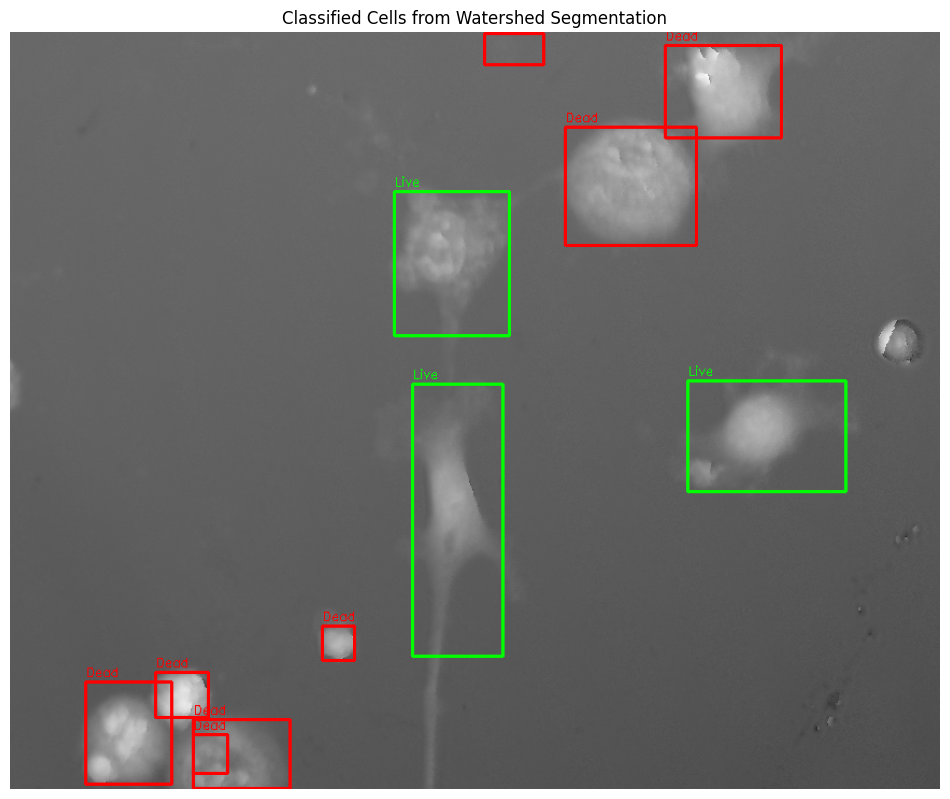

🧠 Live: 0, ☠️ Dead: 11


In [228]:
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image_annotated, cv2.COLOR_BGR2RGB))
plt.title('Classified Cells from Watershed Segmentation')
plt.axis('off')
plt.show()

print(f"🧠 Live: {live_count}, ☠️ Dead: {dead_count}")


In [229]:
output_path = 'classified_fov_result.png'  # or .jpg, .tif, etc.
cv2.imwrite(output_path, image_annotated)
print(f"✅ Saved classified image to: {output_path}")


✅ Saved classified image to: classified_fov_result.png
